A brute force implementation of the multiplicative method for NMF in dask: i.e. converting all array operations to `dask.array` operations. This version does not include the regularization.

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import os
%matplotlib inline

For testing we will use the face dataset used in scikit-learn, which comes from the “Labeled Faces in the Wild” dataset, also known as LFW:

[http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz)


In [2]:
from dask.distributed import Client, progress
c = Client()
c.restart()

Client Scheduler: tcp://127.0.0.1:64998 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [3]:
from dask.array.image import imread
import dask.array as da
from dask import compute

In [4]:
# read the faces dataset
path = 'lfw_funneled'
faces = imread(os.path.join(path,'*','*.jpg'))
q = 2 # subsampling factor
N,m,n,d = faces[:,::q,::q,:].shape


In [5]:
data = faces[:,::q,::q,0].reshape((faces.shape[0],-1))

In [6]:
X_da = c.persist(data[:,:])

In [7]:
# compute for sklearn
X = data[:,:].compute()

In [8]:
from dask.distributed import progress

In [9]:
import time as time

In [10]:
# to avoid deviding by zero
EPSILON = np.finfo(np.float32).eps

In [11]:
# import initialization functions
from dask_nmf import initialize, initialize_da

Numpy Updates:

In [12]:
def update_H(M,H,W):
    denominator = (np.dot(W.T,np.dot(W,H)))
    denominator[np.abs(denominator) < EPSILON] = EPSILON
    H_new = H*np.dot(W.T,M)/denominator
    return(H_new)

In [13]:
def update_W(M,H,W):
    denominator = (np.dot(W,np.dot(H,H.T)))
    denominator[np.abs(denominator) < EPSILON] = EPSILON
    W_new = W*np.dot(M,H.T)/denominator
    return(W_new)

Dask Updates:

In [14]:
def update_H_da(M,H,W):
    denominator = da.dot(W.T,da.dot(W,H))
    denominator_new = da.where(da.fabs(denominator) < EPSILON,EPSILON,denominator) 
    H_new = H*da.dot(W.T,M)/denominator_new
    return(H_new)

In [15]:
def update_W_da(M,H,W):
    denominator = da.dot(W,da.dot(H,H.T))
    denominator_new = da.where(da.fabs(denominator) < EPSILON,EPSILON,denominator) 
    W_new = W*da.dot(M,H.T)/denominator_new
    return(W_new)

Note: the actual scikit learn implementation relies on sparse dot products with the data matrix, which here are not used.

TODO: we can explore how to use [dask sparse arrays](http://dask.pydata.org/en/latest/array-creation.html#store-dask-arrays). 

In [16]:
# number of components
# for now I keep it large because to see the ability to reconstruct (in practice will be much smaller)
k = 100

#### Initialization
The NMF algorithm can take several different initializations:
* random - the absolute value of normally distributed i.i.d. random variables, scaled by the mean of the data
    * random is easiest to implement with `da.random`, but it does not use much the data
* nonnegative double singular value decomposition [ndsvd](https://www.sciencedirect.com/science/article/pii/S0031320307004359)
     * ndsvd requires after running initial svd, running a second one on positive parts of the singular vectors (so it requires some logical operations)
* random_vcol - averaging random data columns
     * random_vcol could be a cheap version for dask as it requires subsetting and averaging random columns from the data, which dask is good at
    

 
More details can be found in the documentation of the [Nimfa](http://nimfa.biolab.si/nimfa.methods.seeding.html) package. For now we only have the random version, and because numpy and dask random functions do not return the same streams we fix them by running one of them below, and then passing the same matrices through a 'custom' initilization option. 

TODO:
* ndsvd
* random column

In [17]:
# initilizing with dask so that we can make the initilization deterministic and compare between numpy and dask
W_init, H_init = initialize_da(X_da,k,init='random')

W_init = W_init.compute().copy()
H_init = H_init.compute().copy()

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [18]:
# numpy fitting function
EPSILON = np.finfo(np.float32).eps
def fit(M, k, nofit, init, W=None, H=None):
    
    W, H = initialize(M, k, init, W, H)
    

    
    err = []
    for it in range(nofit):
        W = update_W(M,H,W)
        #print(np.sum(np.isnan(W)))
        H = update_H(M,H,W)
        err.append(linalg.norm(M - np.dot(W,H)))
        if it%10==0:
            print('Iteration '+str(it)+': error = '+ str(err[it]))
    return(W, H, err)

In [19]:
# dask fitting function
def fit_da(M, k, nofit, init='random', W=None, H=None):
    
    from dask import compute
    
    W, H = initialize_da(M, k, init, W, H)
    
    err = []
    for it in range(nofit):
        W = update_W_da(M,H,W)
        H = update_H_da(M,H,W)
        
        err.append(da.linalg.norm(M - da.dot(W,H)))  
        
    return(W,H,err)

**Chunking**

In this example, the dimensions of the number of the pixels in the image (features) is much bigger than the number of images (samples). So we first consider the case when the images are chunked into small pieces. If the data comes from a sequence of files this usually will not be the case since then each image will be a separate chunk, and the chunk size along the sample dimension will be 1. We can rechunk for testing purposes. 

TODO: explore different chunking strategies

In [20]:
print(X_da.shape)
chunk_size = 625
print(int(X_da.shape[1]/chunk_size))
X_da = X_da.rechunk((X_da.shape[0],chunk_size))

(13233, 15625)
25


In [21]:
nofit = 100

#### numpy

In [22]:
%%time
W, H, err = fit(X, k, nofit = nofit, init = 'custom', W = W_init, H = H_init)

Iteration 0: error = 935512.287563
Iteration 10: error = 929542.439206
Iteration 20: error = 865453.331175
Iteration 30: error = 775136.9149
Iteration 40: error = 701998.044264
Iteration 50: error = 644848.558328
Iteration 60: error = 601065.773848
Iteration 70: error = 567545.585989
Iteration 80: error = 541836.905249
Iteration 90: error = 521900.817913
CPU times: user 19min 10s, sys: 5min 14s, total: 24min 24s
Wall time: 10min 47s


In [23]:
#W

In [24]:
#H

In [25]:
#### plt.plot(err)

In [26]:
data_fitted = np.dot(W,H).reshape(-1,m,n)

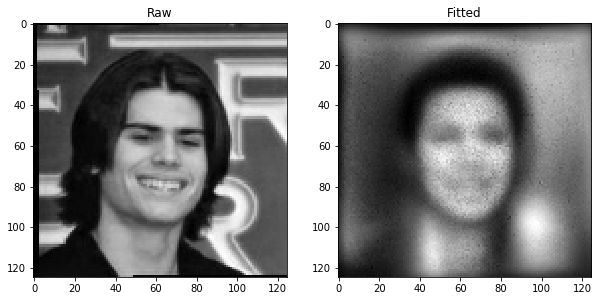

In [27]:
# plot the results
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(faces[1,::q,::q,0],cmap = 'gray')
plt.title('Raw')
    
plt.subplot(1,2,2)
plt.imshow(data_fitted[1,:,:],cmap = 'gray')
plt.title('Fitted')

Note that the multiplicative method does not converge with 100 iterations, hence the bad looking reconstruction. Even when running with 1000 iterations, the algorithm does not converge according to sk-learn rules. Hence, the need to implement the other initialization steps and other optimization methods.

In [28]:
# Using all the faces made the reconstruction worse, remember they are faces in the wild

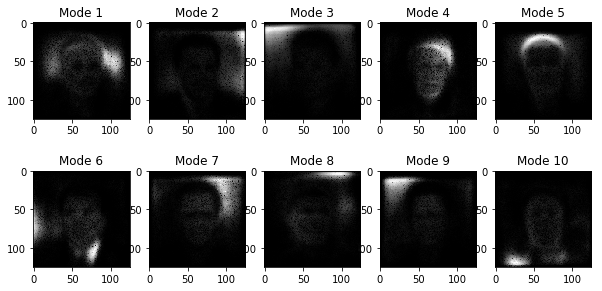

In [29]:
# plot the results
u = H.reshape((-1,m,n))
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(u[i,:,:],cmap = 'gray')
    plt.title('Mode '+str(i+1))

#### scikit-learn

/Users/valentina/anaconda/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


CPU times: user 5min 32s, sys: 23.3 s, total: 5min 55s
Wall time: 1min 46s


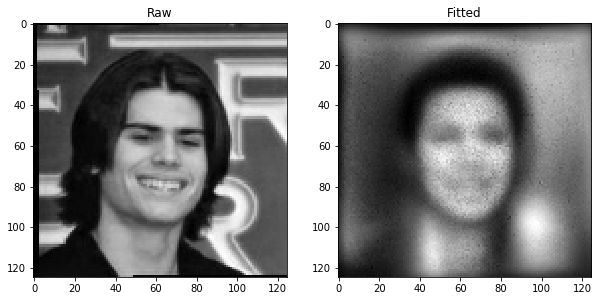

In [30]:
%%time
# compare to sklearn multiplicative method 
# only latest versions have the multiplicative method
# performance seems worse than the coordinate descent method
 
from sklearn.decomposition import NMF
nmf = NMF(n_components = k,init = 'custom',solver = 'mu',max_iter = 100)
W = nmf.fit_transform(X, W=W_init, H=H_init)
H = nmf.components_
data_fitted_sk = np.dot(W,H)

#plot the results
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(faces[1,::q,::q,0],cmap = 'gray')
plt.title('Raw')
    
plt.subplot(1,2,2)
plt.imshow(data_fitted_sk.reshape(-1,m,n)[1,:,:],cmap = 'gray')
plt.title('Fitted')

Note that the scikit-learn implementation is faster than our numpy implementation. Scikit-learn leverages sparse arrays when possible.

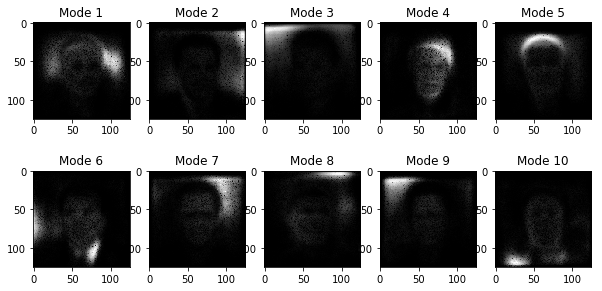

In [31]:
# plot the results
u = H.reshape((-1,m,n))
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow(u[i,:,:],cmap = 'gray')
    plt.title('Mode '+str(i+1))

#### da.array

In [32]:
W, H, err = fit_da(X_da, k, 100, init = 'random')

In [33]:
c.persist(H)

dask.array<truediv, shape=(100, 15625), dtype=float64, chunksize=(100, 625)>

In [67]:
#from IPython.display import HTML
#HTML('<iframe width="315" height="315"  src="https://youtube.com/embed/BG9KiF2-vYk?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>') 

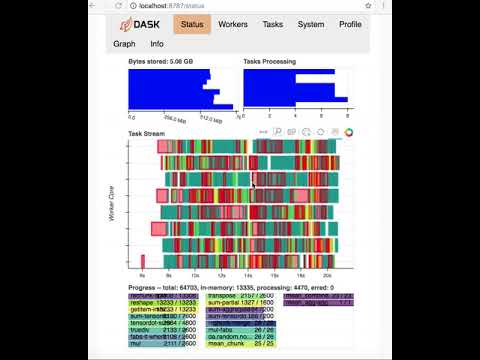

In [66]:
from IPython.display import YouTubeVideo
YouTubeVideo('BG9KiF2-vYk')

Some red, some green.

Well, overall quite a lot of red:

<img src="https://cdn.rawgit.com/valentina-s/daskNMF/master/mu_performance.png" style="width: 200px;"/>


Since the updates involve a lot of linear algrebra operations, they involve communication. 

In [35]:
%%time
W, H, err = compute(W,H,err)



CPU times: user 2min 53s, sys: 39.3 s, total: 3min 32s
Wall time: 10min 56s


In [36]:
progress(W)

In [37]:
data_fitted = np.dot(W,H).reshape(-1,m,n)

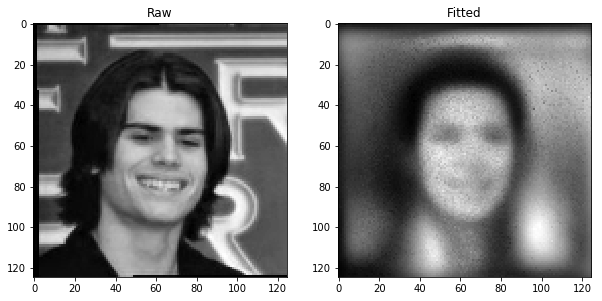

In [38]:

#plot the results
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(faces[1,::q,::q,0],cmap = 'gray')
plt.title('Raw')
    
plt.subplot(1,2,2)
plt.imshow(data_fitted.reshape(-1,m,n)[1,:,:],cmap = 'gray')
plt.title('Fitted')

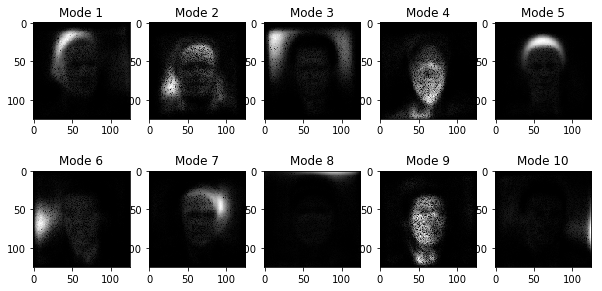

In [39]:

# plot the results
u = H.reshape((-1,m,n))
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow(u[i,:,:],cmap = 'gray')
    plt.title('Mode '+str(i+1))

#### Testing

In [40]:
from sklearn.utils.testing import assert_less

# test function to compare np and da results (to make sure they are equivalent)
def test_nmf_np_da():
    import numpy.linalg as la

    
    X = np.abs(np.random.RandomState(42).normal(0,1,(6, 5)))
    X_da = da.from_array(X, (3,5))
    
    # compare numpy and dask version
    W_init, H_init = initialize_da(X_da,5,init='random')
    W_init = W_init.compute()
    H_init = H_init.compute()
    
    k = 5
    W, H, err = fit(X, k, nofit = 100, init = 'custom', W = W_init, H = H_init)
    W_da, H_da, err = fit_da(X_da, k, nofit = 100, init = 'random')
    diff = la.norm(W_da.compute()-W,'fro')
    print(diff)
    
    assert_less(diff,0.1)


In [41]:
print(test_nmf_np_da())

Iteration 0: error = 2.2153608425
Iteration 10: error = 0.915738099022
Iteration 20: error = 0.481015006617
Iteration 30: error = 0.302768127325
Iteration 40: error = 0.257500017649
Iteration 50: error = 0.229016690614
Iteration 60: error = 0.202684194444
Iteration 70: error = 0.178302120327
Iteration 80: error = 0.157352021602
Iteration 90: error = 0.140568061255
7.01505981399e-15
None


In [42]:
from sklearn.utils.testing import assert_less

# test function to compare da to scikit-learn
def test_nmf_sk_da():
    import numpy.linalg as la

    
    X = np.abs(np.random.RandomState(42).normal(0,1,(6, 5)))
    X_da = da.from_array(X, (3,5))
    
    # compare numpy and dask version
    W_init, H_init = initialize_da(X_da,5,init='random')
    W_init = W_init.compute().copy()
    H_init = H_init.compute().copy()
    
    k = 5
    nofit = 100
    W_da, H_da, err = fit_da(X_da, k, nofit = nofit, init = 'random')
    
    from sklearn.decomposition import NMF
    nmf = NMF(n_components = k, init = 'custom',solver = 'mu',max_iter = nofit)
    W = nmf.fit_transform(X,W=W_init, H=H_init)
    H = nmf.components_
    # data_fitted_sk = np.dot(W,H)
    
    diff = la.norm(W_da.compute()-W,'fro')
    print(diff)
    
    assert_less(diff,0.1)


In [43]:
test_nmf_sk_da()



/Users/valentina/anaconda/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4.01783575181e-15


tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x855ca07b8>, <tornado.concurrent.Future object at 0x84a3ae710>)
Traceback (most recent call last):
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 626, in _discard_future_result
    future.result()
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/Users/valentina/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "/Users/valentina/anaconda/lib/python3.6/site-packa